<a href="https://colab.research.google.com/github/J0SAL/major-project-notebook/blob/main/2_1_word2vec_version_(train_test_split%2C_model_training%2C_testing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## News Sentiment Analysis using RNN LSTM

Dataset: https://www.kaggle.com/datasets/harshrkh/india-financial-news-headlines-sentiments?select=News_sentiment_Jan2017_to_Apr2021.csv


### References: 
1. Youtube: https://youtu.be/2EiA_TA2NJo
2. Kaggle Notebook: https://www.kaggle.com/code/rajmehra03/a-complete-text-classfication-guide-word2vec-lstm



In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.initializers import Constant
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
import gensim
import numpy as np

In [5]:
!pip install -U "tensorflow==2.9.*"
!pip install -U "tensorflow-text==2.9.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 89.5 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
tf.__version__

'2.9.2'

In [8]:
### Vocabulary size => unique words (so every can get unique index)
VOC_SIZE=40000
### vector size for each word
EMBED_DIM=300
### same length  for all the sentences
SENT_LEN=40

EPOCHS = 20
BATCH_SIZE = 100
TEST_SIZE = 0.3

In [9]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/"
DATA_DIR = BASE_DIR+'datasets/'
MODEL_DIR = BASE_DIR+'trained_models/'

# Fetching Preprocessed Data

In [10]:
with open(MODEL_DIR+'corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)
with open(MODEL_DIR+'y.pkl', 'rb') as f:
    y = pickle.load(f)

In [11]:
corpus

['eliminating shadow economy positive impact gdp arun jaitley',
 'two chinese company hit roadblock indian investment',
 'softbank india vision get new',
 'nissan halt joint development luxury car daimler source',
 'despite challenge rajasthan continues progress vasundhara raje',
 'india question composition un panel draft sdg report',
 'wall st flat bank discretionary stock fall tech rise',
 'stock specific pharma auto not convinced sudip bandyopadhyay inditrade capital',
 'cautious pharma time get mahantesh sabarad sbi cap security',
 'rupee gain ground end paisa higher',
 'regulator sebi issue guideline evaluate company board',
 'budget session second phase likely march april',
 'mapping market many psu stock hit',
 'amazon see per cent growth seller base',
 'despite sharekhan acqusition bnp paribas hold stake geojit',
 'tata motor castrol ink three',
 'note ban may temporarily slowdown economy president pranab mukherjee',
 'people complying tax regime incentivised pankaj r patel fi

##### Can be ignored

In [12]:
'''
  generating/verifying constants
'''
# getting unique words
def print_unique(data):
  cnt = set();
  for sentence in data:
    for word in sentence.split():
      cnt.add(word)
  print("unique words: "+ str(len(cnt)))

def max_len_sentence(data):
  max_len = 0
  max_sent = ""
  for sentence in data:
    t = len(sentence.split())
    if max_len < t:
      max_len = t
      max_sent = sentence
  print("sendtence:  ("+ max_sent+") has max length of "+ str(max_len))

# print_unique(corpus)
# max_len_sentence(corpus)

In [13]:
## Tokenizer Playground
def try_tokenizer():  
  t = Tokenizer()

  x = ["This is something bad", "This is something good"]
  y = [0,1]


  t.fit_on_texts(x)

  word_index = t.word_index
  print("word index:\n", word_index)
  print("unique_words: ", len(word_index))

  print("\nDictionary: ")
  for w,i in t.word_index.items():
    print(w,i)

  seq = t.texts_to_sequences(x)
  print("\nSequences: ", seq)

  y = np.asarray(y) # input to array
  print("y: ", y)
# try_tokenizer()

# Generating Own Word Embeddings Model with Word2Vec

In [14]:
def generate_word2vec_tokens(list_of_sentences):
  sentences = []
  for s in list_of_sentences:
    sentences.append(s.split())
  return sentences

def generate_word2vec(sentences):
  w2v_model=gensim.models.Word2Vec(sentences=sentences,size=300,window=10,min_count=1)
  w2v_model.train(sentences,epochs=10,total_examples=len(sentences))
  return w2v_model
  
def save_word2vec(word2vec_model, model_name):
  word2vec_model.wv.save_word2vec_format(MODEL_DIR+model_name, binary=True)

def load_word2vec(model_name):
  loaded_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_DIR+model_name, binary=True)
  return loaded_model

def word2vec_play(model):
  print(len(w2v_model.wv.get_vector('jio')), '\n',w2v_model.wv.get_vector('jio'))

  w2v_model.wv.most_similar('house')

  w2v_model.wv.similarity('good','like')

  vocab=list(w2v_model.wv.vocab.keys())

  print("Vocabulary (total dictionary keys) : ", vocab)

In [15]:
# ss = generate_word2vec_tokens(corpus)
# word2vec_model = generate_word2vec(ss)
# save_word2vec(word2vec_model, 'word2vec/word2vec.bin')
w2v_model = load_word2vec('word2vec/word2vec.bin')

In [16]:
def apply_tokenizer(data):
  tok = Tokenizer(num_words = VOC_SIZE)
  tok.fit_on_texts(corpus)
  encoded_data = tok.texts_to_sequences(corpus) 
  return [tok, encoded_data]
  
def apply_padding(data):
  pad_data = pad_sequences(data, maxlen=SENT_LEN)
  print("New Dimensions: ", pad_data.shape)
  return pad_data

def generate_embedded_matrix(tok, w2v_model):
  embed_matrix=np.zeros(shape=(VOC_SIZE,EMBED_DIM))
  for word,i in tok.word_index.items():
    embed_vector=w2v_model.wv.get_vector(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
      embed_matrix[i]=embed_vector
  return embed_matrix

In [17]:
tok, encoded_corpus = apply_tokenizer(corpus)

In [18]:
pad_corpus = apply_padding(encoded_corpus)

New Dimensions:  (200500, 40)


In [19]:
embed_matrix = generate_embedded_matrix(tok, w2v_model)

<ipython-input-16-9e55257125f8>:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embed_vector=w2v_model.wv.get_vector(word)


In [20]:
def compare_ori_embed():
  s = corpus[0]
  for word in s.split():
    print(word + " ~ " + str(tok.word_index[word]) + " ~ " + str(embed_matrix[tok.word_index[word]]))
    print("\n")
# compare_ori_embed()

In [21]:
# print(embed_matrix[14] == w2v_model.wv.get_vector('rbi'))

# Creating Train & Test Data

In [22]:
import numpy as np
X_final=pad_corpus
y_final= np.array(y) 

In [23]:
X_final.shape,y_final.shape

((200500, 40), (200500,))

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=TEST_SIZE, random_state=42)

In [25]:
acc = []
models = []

In [26]:
# Create Model
def create_model(MODEL):
  model=Sequential()
  model.add(Embedding(input_dim=VOC_SIZE,output_dim=EMBED_DIM,input_length=SENT_LEN,embeddings_initializer=Constant(embed_matrix)))
  model.add(Dense(256))
  model.add(Dropout(0.05))
  model.add(MODEL)
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  return model

# Train Model
def train_model(MODEL, x_train, y_train):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
  # callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0025)
  MODEL.fit(
      x_train,
      y_train, 
      validation_split=0.1, 
      epochs=EPOCHS, 
      shuffle=True, 
      batch_size=BATCH_SIZE
      ,callbacks=[earlystop]
  )

def generate_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test,y_pred)

  ax = plt.subplot()
  sns.set(font_scale=3.0) # Adjust to fit
  sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

  label_font = {'size':'18'}  # Adjust to fit
  ax.set_xlabel('Predicted labels', fontdict=label_font);
  ax.set_ylabel('True labels', fontdict=label_font);

  ax.set_title('Confusion Matrix', fontdict=label_font);

  ax.xaxis.set_ticklabels(['Real', 'Fake']);
  ax.yaxis.set_ticklabels(['Real', 'Fake']);
  plt.show()

def save_model_accuracy(model_name, accuracy):
  acc.append(accuracy)
  models.append(model_name)

def generate_classification_report(y_test, y_pred):
  print(classification_report(y_test,y_pred))

# Test Model
def test_model(MODEL, model_name, x_test, y_test):
  y_pred=MODEL.predict(x_test)
  y_pred=np.where(y_pred >= 0.5, 1,0)
  score = accuracy_score(y_pred,y_test)
  print('Model Accuracy: ',score)
  print("\n\n")
  generate_confusion_matrix(y_test, y_pred)
  print("\n\nClassification Report")
  generate_classification_report(y_test,y_pred)
  save_model_accuracy(model_name, score)

# save model
def save_model(MODEL, model_name):
  MODEL.save(MODEL_DIR+model_name)
  
# load model
def load_model(model_name):
  loaded_model = tf.keras.models.load_model(MODEL_DIR+model_name)
  return loaded_model

# save pickle 
def save_pi_model(MODEL, model_name):
  with open(MODEL_DIR + model_name, 'wb') as f:
    pickle.dump(MODEL, f)

# load pickle
def load_pi_model(model_name):
  with open(MODEL_DIR + model_name, 'rb') as f:
    loaded_model = pickle.load(f)
  return loaded_model

# RNN LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           12000000  
                                                                 
 dense (Dense)               (None, 40, 256)           77056     
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 12,602,625
Trainable params: 12,602,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1805/1805 [======================

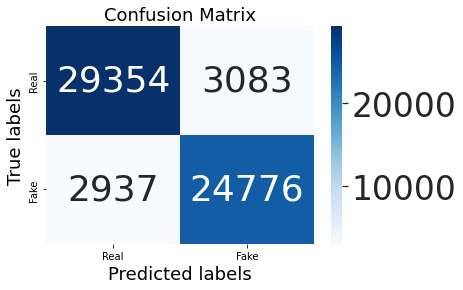



Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     32437
           1       0.89      0.89      0.89     27713

    accuracy                           0.90     60150
   macro avg       0.90      0.90      0.90     60150
weighted avg       0.90      0.90      0.90     60150



In [27]:
lstm_model=create_model(LSTM(256))
train_model(lstm_model, X_final, y_final)
test_model(lstm_model,"RNN_LSTM", X_test, y_test)
save_model(lstm_model, 'word2vec/rnn_lstm.h5')
# loaded_model = load_model('word2vec/rnn_lstm.h5')

# RNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 300)           12000000  
                                                                 
 dense_2 (Dense)             (None, 40, 256)           77056     
                                                                 
 dropout_1 (Dropout)         (None, 40, 256)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 12,208,641
Trainable params: 12,208,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1805/1805 [====================

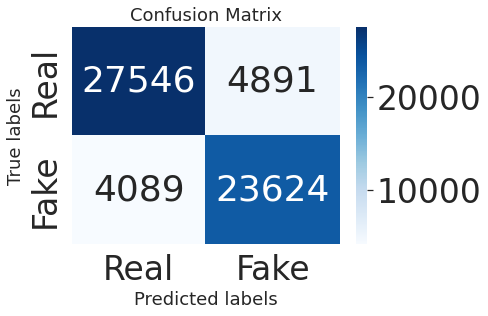



Classification Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     32437
           1       0.83      0.85      0.84     27713

    accuracy                           0.85     60150
   macro avg       0.85      0.85      0.85     60150
weighted avg       0.85      0.85      0.85     60150



In [28]:
rnn_model = create_model(SimpleRNN(256))
train_model(rnn_model, X_final, y_final)
test_model(rnn_model,"Simple_RNN", X_test, y_test)
save_model(rnn_model, 'word2vec/rnn.h5')
# loaded_model = load_model('word2vec/rnn.h5')

# RNN GRU

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 300)           12000000  
                                                                 
 dense_4 (Dense)             (None, 40, 256)           77056     
                                                                 
 dropout_2 (Dropout)         (None, 40, 256)           0         
                                                                 
 gru (GRU)                   (None, 256)               394752    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 12,472,065
Trainable params: 12,472,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1805/1805 [====================

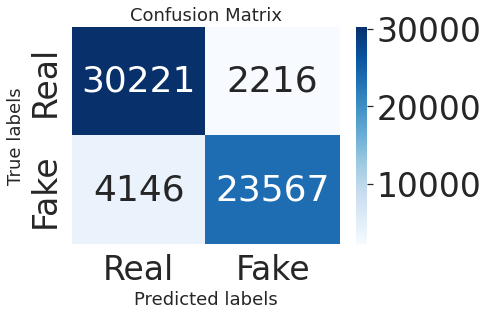



Classification Report
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     32437
           1       0.91      0.85      0.88     27713

    accuracy                           0.89     60150
   macro avg       0.90      0.89      0.89     60150
weighted avg       0.90      0.89      0.89     60150



In [29]:
rnn_gru = create_model(GRU(256))
train_model(rnn_gru, X_final, y_final)
test_model(rnn_gru,"RNN_GRU", X_test, y_test)
save_model(rnn_gru, 'word2vec/rnn_gru.h5')

# Bidirectional RNN LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 300)           12000000  
                                                                 
 dense_6 (Dense)             (None, 40, 256)           77056     
                                                                 
 dropout_3 (Dropout)         (None, 40, 256)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1050624   
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 13,128,193
Trainable params: 13,128,193
Non-trainable params: 0
__________________________________________

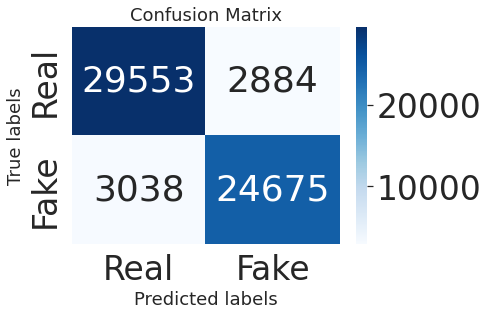



Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     32437
           1       0.90      0.89      0.89     27713

    accuracy                           0.90     60150
   macro avg       0.90      0.90      0.90     60150
weighted avg       0.90      0.90      0.90     60150



In [30]:
bi_lstm = create_model(Bidirectional(LSTM(256)))
train_model(bi_lstm, X_final, y_final)
test_model(bi_lstm,"Bidirectional_LSTM_RNN", X_test, y_test)
save_model(bi_lstm, 'word2vec/bi_lstm_rnn.h5')
# loaded_model = load_model('word2vec/bi_lstm_rnn.h5')

# Naive Bayes

Model Accuracy:  0.5320864505403159





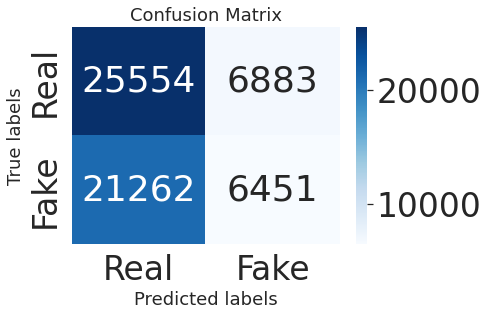



Classification Report
              precision    recall  f1-score   support

           0       0.55      0.79      0.64     32437
           1       0.48      0.23      0.31     27713

    accuracy                           0.53     60150
   macro avg       0.51      0.51      0.48     60150
weighted avg       0.52      0.53      0.49     60150



In [31]:
nb_model = MultinomialNB()
nb_model.fit(X_final, y_final)
test_model(nb_model,"Naive_Bayes", X_test, y_test)
save_pi_model(nb_model, 'word2vec/nb_model.pkl')
# lm = load_pi_model('word2vec/nb_model.pkl')

# Support Vector Machine

In [32]:
# classifier_linear = svm.LinearSVC()
# classifier_linear.fit(X_train, y_train)
# test_model(classifier_linear,"SVM", X_test, y_test)
# save_pi_model(classifier_linear, 'word2vec/svm.pkl')
# lm = load_pi_model('word2vec/svm.pkl')

# Accuracy Comparision

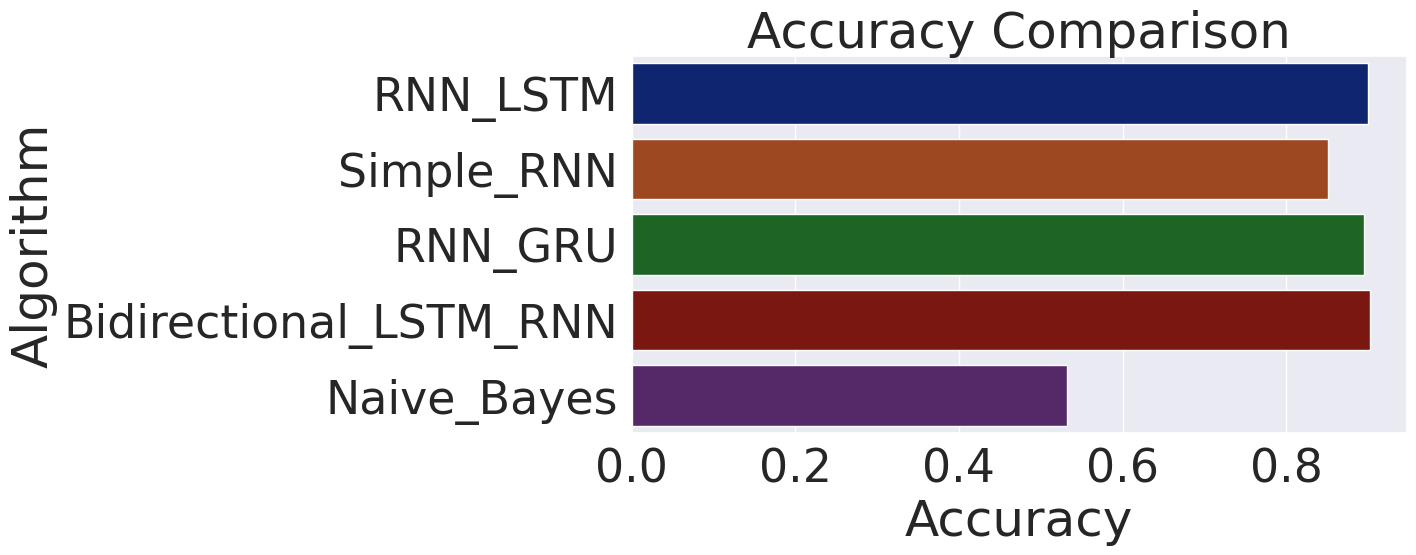

In [33]:
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = models,palette='dark')

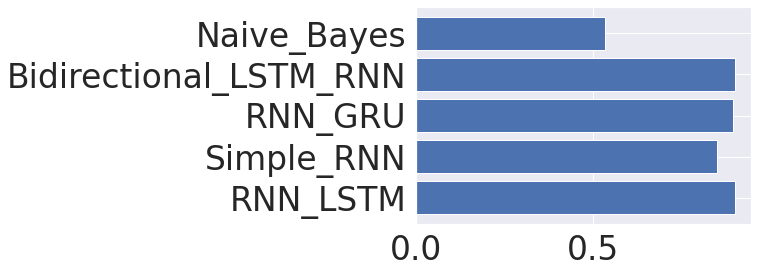

In [34]:
x = np.array(models)
y = np.array(acc)

plt.barh(x,y)
plt.show()

In [35]:
print("Model \t\t\t Accuracy")
for i in range(len(acc)):
  print(models[i],"\t\t", acc[i])

Model 			 Accuracy
RNN_LSTM 		 0.8999168744804655
Simple_RNN 		 0.8507065669160432
RNN_GRU 		 0.8942310889443059
Bidirectional_LSTM_RNN 		 0.9015461346633417
Naive_Bayes 		 0.5320864505403159
